## Data download and modules installation

In [ ]:
!wget -nc https://storage.yandexcloud.net/datasouls-ods/materials/9c6913e5/retailhero-uplift.zip
!unzip -n retailhero-uplift.zip

!pip install causalml -q
!pip install scikit-uplift -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(0)

from tqdm.notebook import tqdm as tqdm_notebook

## Data preprocessing

In [ ]:
def x5_coding(x):
    return int(str(x['treatment_flg'])+str(x['target']), 2)

def x5_preprocessing(df_clients, df_train):
    df_clients['first_issue_unixtime'] = pd.to_datetime(df_clients['first_issue_date']).astype(int)/10**9
    # NaT imputation
    min_redeem_date = pd.to_datetime(df_clients["first_redeem_date"]).min()
    df_clients['first_redeem_unixtime'] = pd.to_datetime(df_clients["first_redeem_date"]).fillna(min_redeem_date).astype(int)/10**9
    df_features = pd.DataFrame({
    'gender_M': (df_clients['gender'] == 'M').astype(int),
    'gender_F': (df_clients['gender'] == 'F').astype(int),
    'gender_U': (df_clients['gender'] == 'U').astype(int),
    'age': df_clients['age'],
    'first_issue_time': df_clients['first_issue_unixtime'],
    'first_redeem_time': df_clients['first_redeem_unixtime'],
    'issue_redeem_delay': df_clients['first_redeem_unixtime'] - df_clients['first_issue_unixtime'],
    }).fillna(0)
    df_train['coding'] = df_train.apply(x5_coding, axis=1)
    w = df_train['treatment_flg']
    y = df_train['target']
    c = df_train['coding']
    return df_features, w, y, c

In [ ]:
df_clients = pd.read_csv('data/clients.csv', index_col='client_id')
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
df_features, w, y, c = x5_preprocessing(df_clients, df_train)

indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3)
X_train, w_train, y_train, c_train = df_features.loc[indices_learn], w.loc[indices_learn], y.loc[indices_learn], c.loc[indices_learn]
X_valid, w_valid, y_valid, c_valid = df_features.loc[indices_valid], w.loc[indices_valid], y.loc[indices_valid], c.loc[indices_valid]

## Target transformation
$$
z_i = \begin{cases}
2, & \text{if $w_i = 1$, $y_i=1$} \\
-2, & \text{if $w_i = 0$, $y_i=1$}  \\
0 & \text{otherwise}
\end{cases}
$$

In [ ]:
def get_z(x):
    if x["treatment_flg"] == 1 and x["target"] == 1:
        return 2
    if x["treatment_flg"] == 0 and x["target"] == 1:
        return -2
    return 0

z_train = pd.concat((w_train, y_train), axis=1).apply(get_z, axis=1)
z_valid = pd.concat((w_valid, y_valid), axis=1).apply(get_z, axis=1)

<!-- * Модель $\mu(\tilde{X})$, $\tilde{X} = \left(X \mid w\right)$ -->
* Model $\mu$ takes as input client feature vector concatenated with treatment flag
* Predicted value is $\hat{y}_i =
\begin{cases}
\mu(x_i), & \text{если $w_i = 1$}\\
-\mu(x_i), & \text{если $w_i = 0$}
\end{cases}
$
* $\text{Loss} = \text{MSE}(\hat{y}, y)$

## Loss definition

In [ ]:
def uplift_loss(y_true, y_pred, w):
    mask_t = w == 1
    mask_c = w == 0
    y_pred_cp = y_pred.clone()
    y_pred_cp[mask_c] = -y_pred_cp[mask_c]
    loss = criterion(y_pred_cp, y_true)
    return loss

## Dataset construction

In [ ]:
class X5_data(Dataset):
    def __init__(self, X, w, z=None, y=None, valid=False):
        super(X5_data, self).__init__()
        assert X.shape[0] == w.shape[0]
        # assert X.shape[0] == z.shape[0]
        X = np.asarray(X)
        w = np.asarray(w)
        z = np.asarray(z)
        X = np.hstack((X, w.reshape(-1, 1)))   # concatenate features with treatment flag
        self.X = torch.tensor(X, dtype=torch.float32)
        self.w = torch.tensor(w, dtype=torch.int32)
        self.valid = valid
        self.z = torch.tensor(z, dtype=torch.float32)
        if self.valid == True:
            self.y = torch.tensor(y, dtype=torch.int32)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.valid == False:
            return self.X[idx], self.w[idx], self.z[idx]
        return self.X[idx], self.w[idx], self.y[idx], self.z[idx]
        

In [ ]:
X_train_sc = MinMaxScaler().fit_transform(X_train)
X_valid_sc = MinMaxScaler().fit_transform(X_valid)

train_ds = X5_data(X_train_sc, w_train, z=z_train, valid=False)
valid_ds = X5_data(X_valid_sc, w_valid, y=y_valid, z=z_valid, valid=True)

train_loader = DataLoader(train_ds, batch_size=50, shuffle=True) 
valid_loader = DataLoader(valid_ds, batch_size=len(valid_ds), shuffle=False) 

In [ ]:
class SmiteModel(nn.Module):
    def __init__(self, in_size):
        super(SmiteModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 300),
            nn.LeakyReLU(inplace=True),
            nn.Linear(300, 100),
            nn.LeakyReLU(inplace=True),
            nn.Linear(100, 50),
            nn.LeakyReLU(inplace=True),
            nn.Linear(50, 10),
            nn.LeakyReLU(inplace=True),
        )
        self.last = nn.Linear(10, 1)
    def forward(self, x):
        out = self.last(self.net(x))
        return out

In [ ]:
model = SmiteModel(X_train.shape[1] + 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

Epoch 40/41
Loss: train 0.9627 valid 1.0002
Metrics:  0.0078 -0.0031


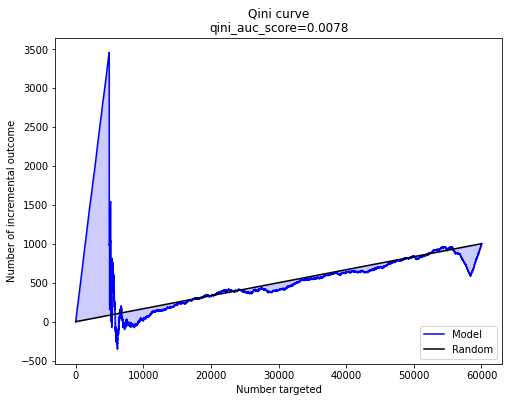

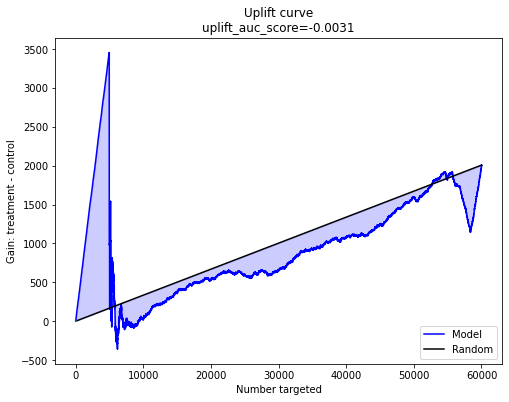

In [ ]:
N_epochs = 41
train_loss = []
valid_loss = []
metrics = np.zeros((N_epochs, 2))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in tqdm_notebook(range(N_epochs)):
    model.train()
    losses = []
    for X, w, z in train_loader:
        X = X.to(device)
        z = z.to(device)
        out = model(X)
        optimizer.zero_grad()
        loss = uplift_loss(z, out.ravel(), w)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    train_loss.append(np.mean(losses))

    model.eval()
    losses = []
    qini_aucs, uplift_aucs, wau_aucs = [], [], []
    for X, w, y, z in valid_loader:
        X = X.to(device)
        z = z.to(device)
        mask_t = w == 1
        mask_c = w == 0
        out = model(X)
        loss = uplift_loss(z, out.ravel(), w)
        losses.append(loss.item())

        pred_val = out.cpu().detach().numpy().ravel()
        qini_auc = qini_auc_score(y_true=y.numpy().ravel(), uplift=pred_val, treatment=w.numpy().ravel())
        qini_aucs.append(qini_auc)
        uplift_auc = uplift_auc_score(y_true=y.numpy().ravel(), uplift=pred_val, treatment=w.numpy().ravel())
        uplift_aucs.append(uplift_auc)
        # wau_auc = weighted_average_uplift(y_true=y.numpy().ravel(), uplift=pred_val, treatment=w.numpy().ravel())
        # wau_aucs.append(wau_auc)
    metrics[epoch] = np.mean(qini_aucs), np.mean(uplift_aucs)#, np.mean(wau_aucs)

    valid_loss.append(np.mean(losses))
    if epoch % 10 == 0:
        clear_output()
        print(f"Epoch {epoch}/{N_epochs}\nLoss: train {train_loss[-1]:.4f} valid {valid_loss[-1]:.4f}\nMetrics: {np.array2string(metrics[epoch], precision=4)[1:-1]}")
        plot_qini_curve(y_true=y.cpu().detach().numpy().ravel(), uplift=pred_val, treatment=w.cpu().detach().numpy().ravel(), perfect=False)
        plot_uplift_curve(y_true=y.cpu().detach().numpy().ravel(), uplift=pred_val, treatment=w.cpu().detach().numpy().ravel(), perfect=False)
        plt.plot(metrics[:epoch,0])
        plt.show()

In [ ]:
# torch.save(model.state_dict(), "/content/drive/MyDrive/ML2021_project/model.pth")

In [ ]:
X_tilde = np.hstack((X_valid_sc, w_valid.values.reshape(-1, 1)))
X_tilde = torch.tensor(X_tilde, dtype=torch.float32).to(device)
y_pred_valid = model(X_tilde)
y_pred_valid = y_pred_valid.cpu().detach().numpy().ravel()

## Final validation metrics

In [ ]:
qini_auc_score(y_true=y_valid, uplift=y_pred_valid, treatment=w_valid)

0.00776011382458551

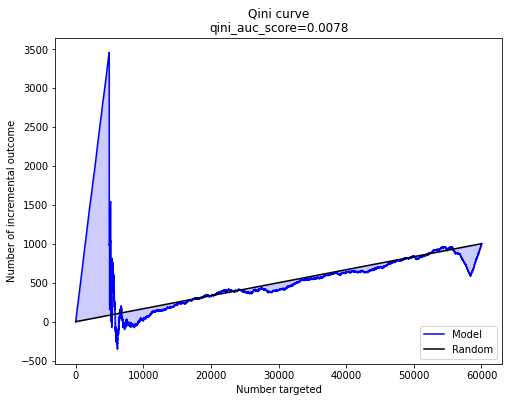

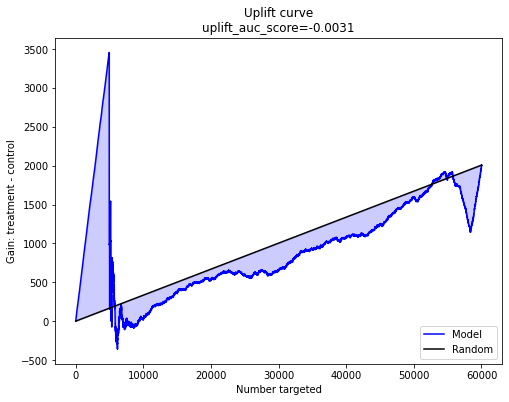

In [ ]:
plot_qini_curve(y_true=y_valid, uplift=y_pred_valid, treatment=w_valid, perfect=False)
plot_uplift_curve(y_true=y_valid, uplift=y_pred_valid, treatment=w_valid, perfect=False)